In [1]:
import numpy as np
from scipy import stats
import scipy.optimize as sco
from scipy.optimize import curve_fit

import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import echelle

## Reading files

In [6]:
def get_data(ref,dir_path="data/Kepler/"):
    header = {}
    data_spec = []
    data_temp = []
    with open(dir_path+"spec_"+ref+".txt","r") as f_s:
        while True:
            line = f_s.readline()
            # if file end; exit
            if not line:
                break
                
            # if coment line or non params line
            if "###" in line or len(line.split())<2 or len(line.split())>3:
                continue
            
            # if params line, create header
            elif line.startswith("#"):
                vals = "".join(line.split("#")).split()
                try:
                    vals[1] =  float(vals[1])
                except:
                    pass
                header[vals[0]] = vals[1]
            # if else, append data values
            else:
                vals = line.strip().split()
                data_spec.append([float(vals[0]),float(vals[1])])
                
    with open(dir_path+"temp_"+ref+".txt","r") as f_s:
        while True:
            line = f_s.readline()
            # if file end; exit
            if not line:
                break
            if "#" in line:
                continue
            else:
                vals = line.strip().split()
                data_temp.append([float(vals[0]),float(vals[1])])
                
    return header,np.array(data_spec), np.array(data_temp) 

# Visualizing data

In [7]:
#choose a star reference
star_ref = "001723700"

hdr,data_spec,data_temp = get_data(star_ref)

# epsilon value
eps = hdr["epsilon"]
# delta nu
dnu = hdr["Dnu"]
# alpha
alpha = hdr["alpha"]

# nu max
numax = hdr["numax"]

# n max 
n_max = (numax/dnu)-eps
print(hdr)

{'mission': 'Kepler', 'ID': 1723700.0, 'numax': 39.23, 'Dnu': 4.483, 'epsilon': 0.961, 'alpha': 0.0098, 'magV': 0.0, 'Teff': 4896.0, 'logg': 2.53, 'Z': -0.34}


In [58]:
hdr

{'mission': 'Kepler',
 'ID': 1723700.0,
 'numax': 39.23,
 'Dnu': 4.483,
 'epsilon': 0.961,
 'alpha': 0.0098,
 'magV': 0.0,
 'Teff': 4896.0,
 'logg': 2.53,
 'Z': -0.34}

## Plotting raw data

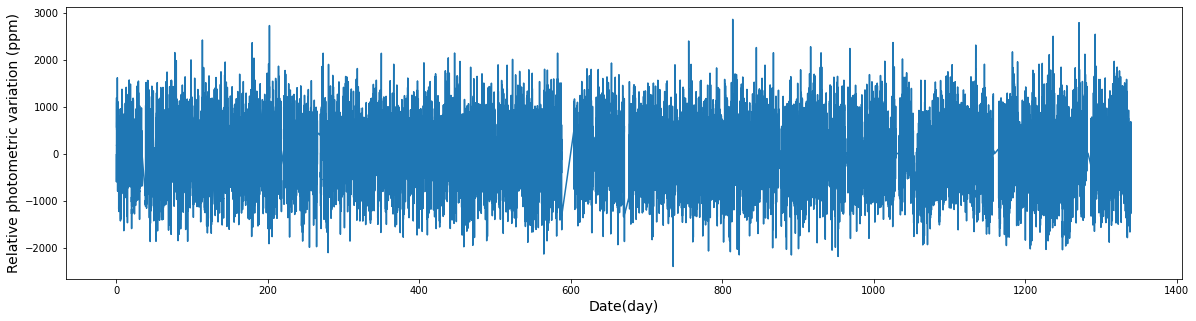

In [8]:
plt.figure(figsize=(20,5))
plt.xlabel("Date(day)",fontsize = 14)
plt.ylabel("Relative photometric variation (ppm)",fontsize = 14)
plt.plot(data_temp[:,0],data_temp[:,1])

In [9]:
# one cycle per day has 24 hrs, 3600 seconds each. one million microseconds per second
conver_f = 1e6*(1/(3600*24)) #  cycle per Day to microHz

# calculate the sampling frequency by averaging the differences between contiguous timesteps
dt = np.mean([data_temp[i+1,0]-data_temp[i,0] for  i in range(len(data_temp)-1)])
# Nyquist frequency to limit useful spectra
NyqF_cpd = 1/(2*dt)
NyqF_mhz = conver_f/(2*dt)


print("Dt found: {:.3f} days".format(dt))
print("          {:.3f} s".format(dt*3600*24))
print("1 Cycle per day (cpd) is equivalent to {:.3f} microHz".format(conver_f))
print("Nyquist frequency: {:.3f} cpd".format(NyqF_cpd))
print("                   {:.3f} microHz \n".format(NyqF_cpd*conver_f))


Dt found: 0.022 days
          1857.602 s
1 Cycle per day (cpd) is equivalent to 11.574 microHz
Nyquist frequency: 23.256 cpd
                   269.164 microHz 



### Generating Lomb Scargle periodogram and comparing with provided spectra
This was not necessary, but i wanted to explore the LS periodogram function and the possible differences between this spectra and the one provided. 

/home/localuser/Documents/work_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


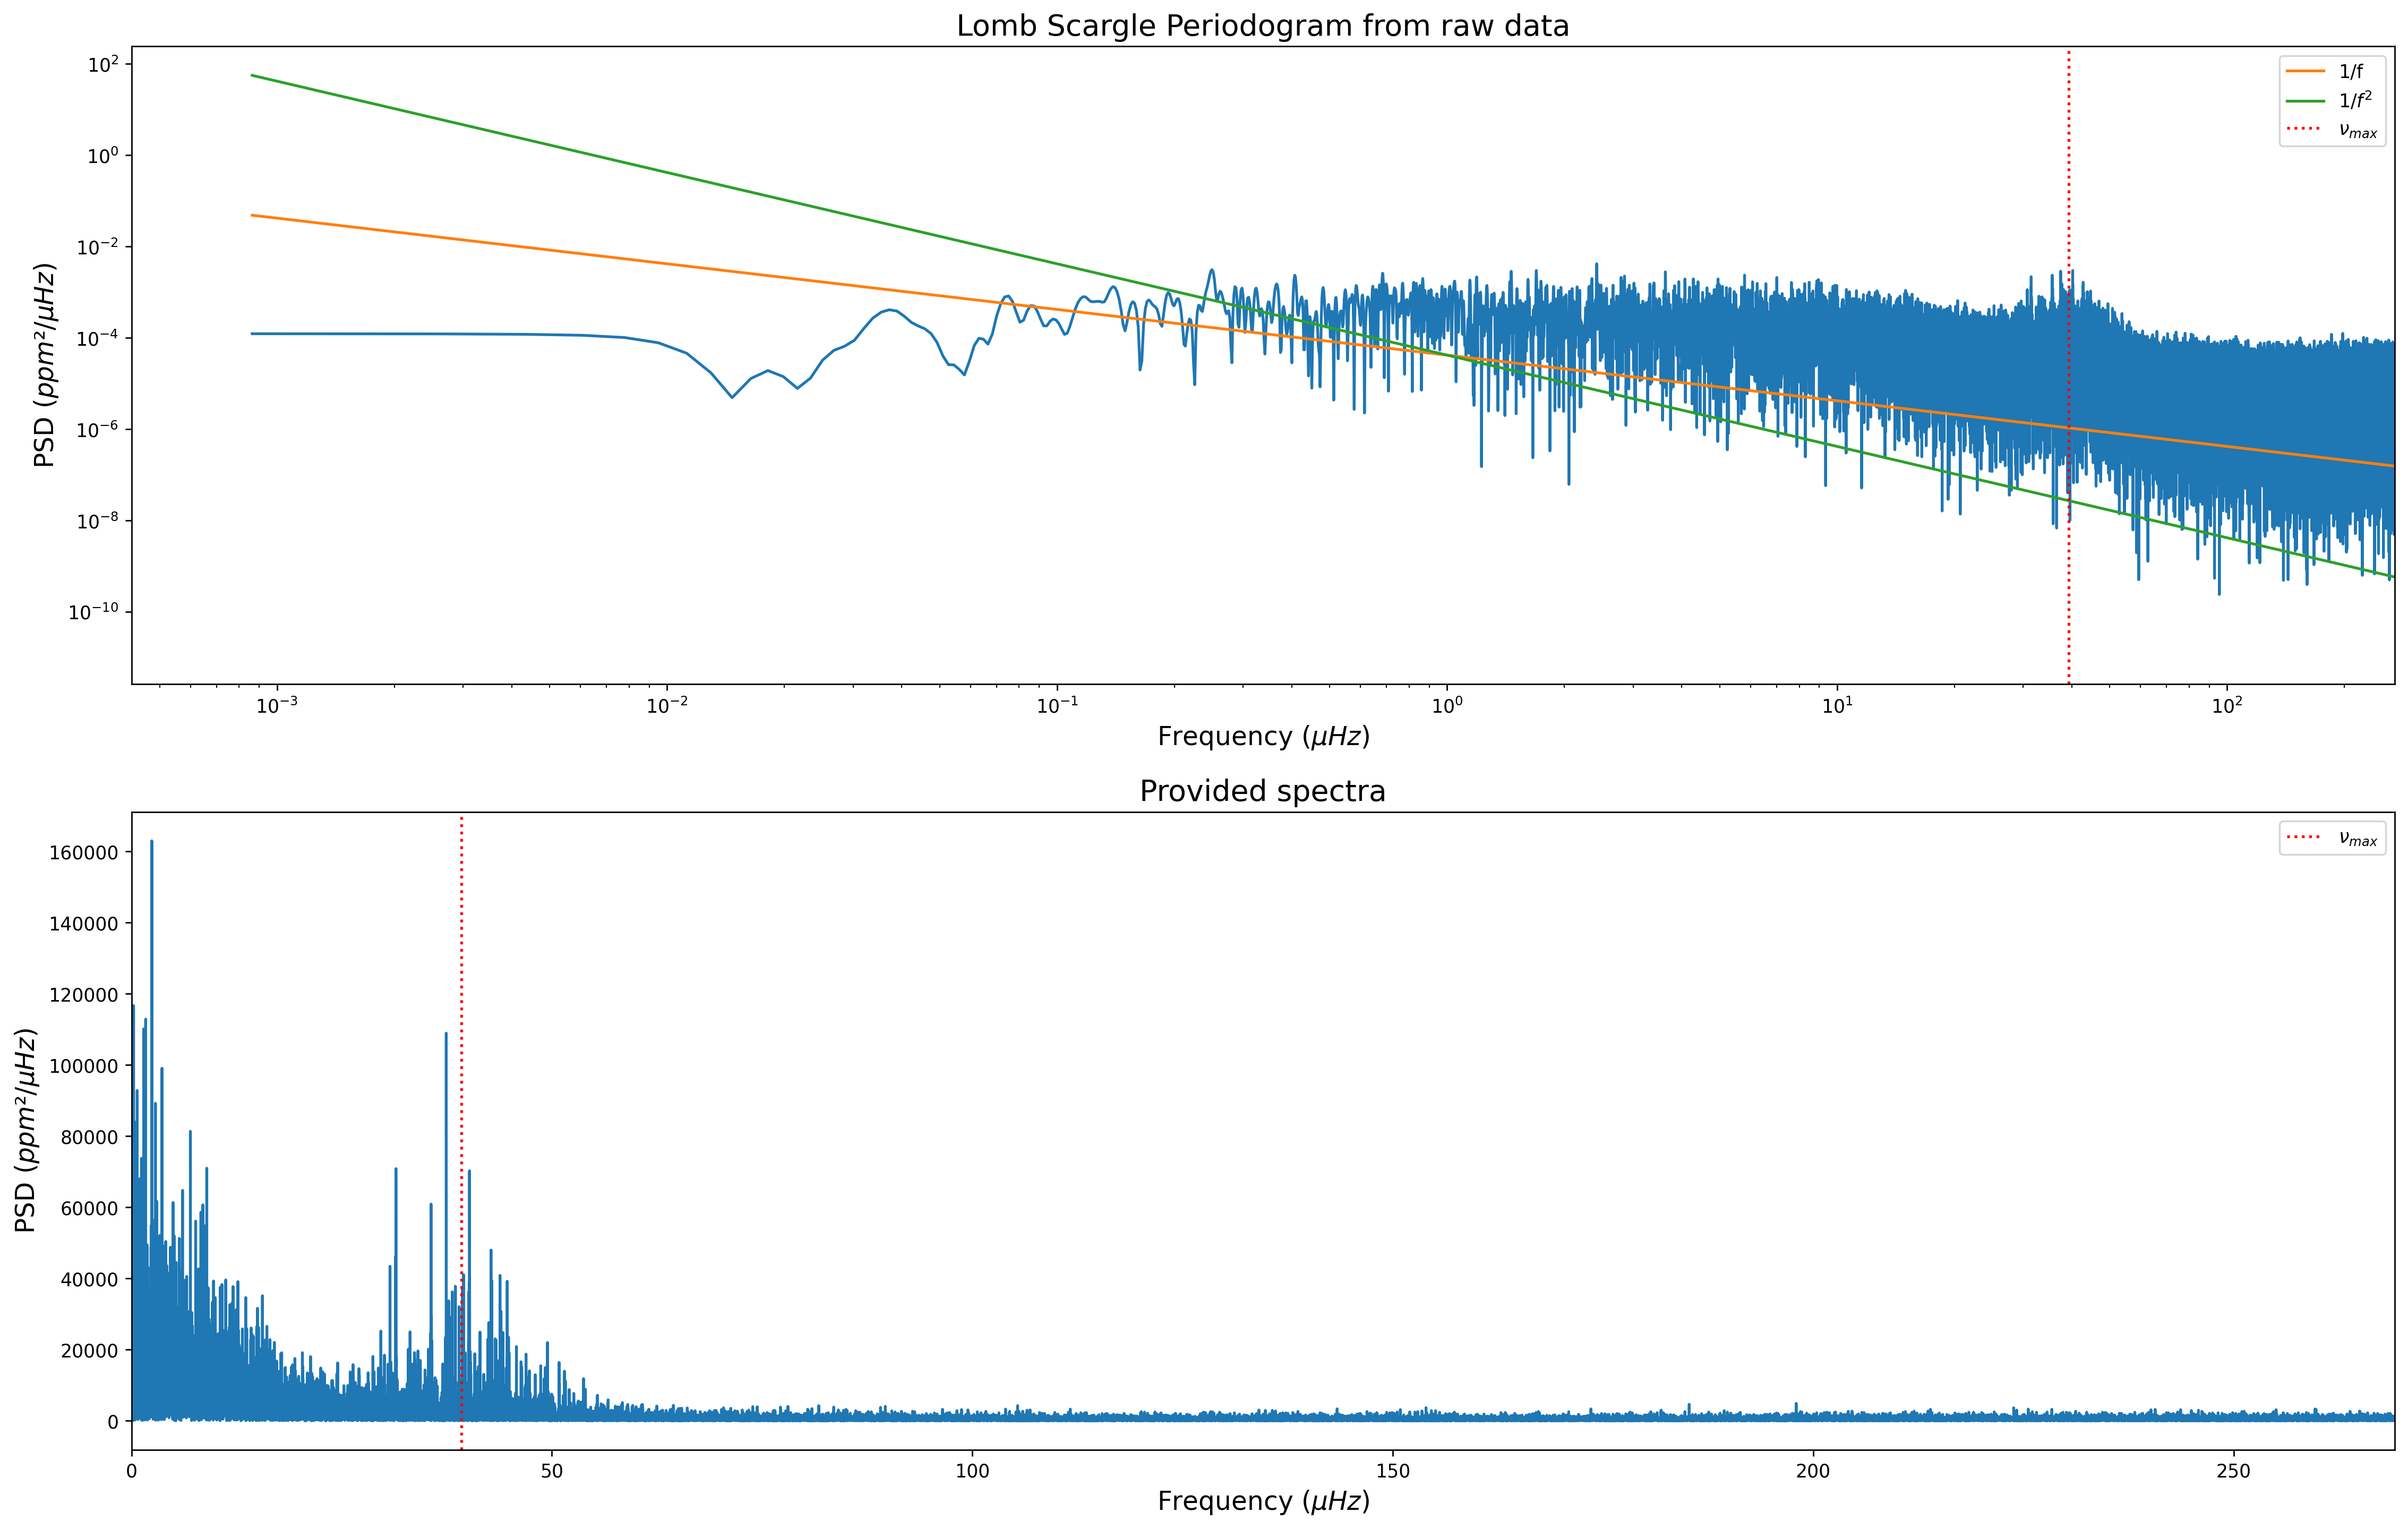

In [10]:
frequencyLS, powerLS = LombScargle(data_temp[:,0], data_temp[:,1],fit_mean=True,normalization="standard").autopower()
plt.figure(figsize=(22,14),dpi=250)
plt.subplot(2,1,1)
plt.title("Lomb Scargle Periodogram from raw data",fontsize=16)
plt.plot(frequencyLS*conver_f,powerLS)
plt.plot(frequencyLS*conver_f,np.mean(powerLS)/(frequencyLS*conver_f)**1,label="1/f")
plt.plot(frequencyLS*conver_f,np.mean(powerLS)/(frequencyLS*conver_f)**2,label="1/$f^2$")
#NOISE
#plt.plot(frequencyLS*conver_f,(1/frequencyLS)*conver_f*np.mean(powerLS))
#plt.plot(frequencyLS*conver_f,(1/np.sqrt(frequencyLS))*conver_f*np.mean(powerLS))
#plt.plot(frequencyLS*conver_f,(1/frequencyLS**2)*conver_f*np.mean(powerLS))

plt.xlabel("Frequency ($\mu Hz$)",fontsize = 14)
plt.ylabel("PSD ($ppm² / \mu Hz $)",fontsize = 14)
plt.yscale("log")
plt.xscale("log")
plt.xlim(0,NyqF_mhz)
plt.axvline(numax,c="r",linestyle=":",label="$\\nu_{max}$")
plt.legend()
plt.subplot(2,1,2)
plt.title("Provided spectra",fontsize=16)
plt.xlabel("Frequency ($\mu Hz$)",fontsize = 14)
plt.ylabel("PSD ($ppm² / \mu Hz $)",fontsize = 14)
plt.plot(data_spec[:,0],data_spec[:,1])
#plt.yscale("log")
plt.xlim(0,NyqF_mhz)
plt.axvline(numax,c="r",linestyle=":",label="$\\nu_{max}$")
plt.legend()

In [11]:
# model of the lorenzian profile for the peaks
def lorentzian(x,H,Gamma,nu):
    return H/( 1 + (4/Gamma**2)*(x-nu)**2 )

# obtianing the central nu for defined parameters n,l 
def central_nu(n,l,e,d_nu,do,alpha,nmax):
    return (n + (l/2) + e +do+(alpha/2)*(n-nmax)**2)*d_nu
# modeling the height of the peaks AKA the gaussian envelope
def height(x,A,nu,sigma):
    return A * np.exp(-((x-nu)**2)/(2*sigma**2))

# generate multiplet of peaks
def gen_peaks_set(x,params,fixed):
    
    y = np.zeros([len(x)])
    
    do = 0
    try:
        do =fixed["dol"][int(params["l"])-1]
    except:
        do = 0
    cnu = central_nu(params["n"],params["l"],fixed["eps"],fixed["d_nu"],do,fixed["alpha"],fixed["n_max"])
    ms = list(np.arange(-params["l"],params["l"]+1))
    for m in ms:
        
        nu_nlm = cnu + m * fixed["d_nu"]    
        H = height(nu_nlm,10**params["log_A"],cnu,params["sigma"])
        #print(nu_nlm,H)
        
        y = y + lorentzian(x,H,params["Gamma"],nu_nlm)
        
    return y+10**params["log_S0"]

# estimate a likelihoodfunction with the squared differences average 
def MSE_loglikelihood(y_dat,y_hyp):
    N = len(y_dat)
    dif = (y_dat-y_hyp)/np.std(y_dat)
    msevalue = -(1/N)*np.sum(dif**2)
    #print(msevalue)
    return msevalue



# Prior to keep every parameter in desired range
# prior = 1 for in range values (logprior=0)
# prior = 0 for out of range values (logprior=-inf)
def logprior(params,params_space):
    p = -np.inf
    in_range = [np.logical_and(params[p]>=params_space[p]["lims"][0] ,params[p]<=params_space[p]["lims"][1]) for p in list(params.keys())  ]
    if(np.sum(in_range) == len(params.keys())):
        p = 0
    return p
    
def loglikelihood(x,y_ref,params,fixed):
    y_hyp = gen_peaks_set(x,params,fixed)
    return MSE_loglikelihood(y_ref,y_hyp)



def MCMC_fit(x,y,Nsteps,params_space,fixed):
    Nsteps = int(Nsteps)
    param_names = list(params_space.keys())
    nparams = len(param_names)
    params_steps = np.zeros([nparams,Nsteps])
    likelihoodvals = np.zeros([Nsteps])
    
    for i in range(Nsteps):
        
        #for the first step choose the initial position 
        if i == 0:
            
            params_steps[:,i] = [params_space[param_names[j]]["init"] for j in range(nparams)]
            in_params = {param_names[j]:params_steps[j,i] for j in range(nparams)}
            loglike = loglikelihood(x,y,in_params,fixed)
            
            logposterior = loglike + logprior(in_params,params_space)
            likelihoodvals[i] = logposterior
            
        else:
            proposed = np.zeros([nparams])
            prev_logposterior = likelihoodvals[i-1]
            for p in range(nparams):
                delta = params_space[param_names[p]]["delta"]
                lims = params_space[param_names[p]]["lims"]
                is_int = params_space[param_names[p]]["integer"]
                
                prev_val = params_steps[p,i-1]

                
                if(is_int):
                    proposed[p] = int(np.random.normal(prev_val,delta))
                else:
                    proposed[p] = np.random.normal(prev_val,delta)
            
            prop_params = {param_names[j]:proposed[j] for j in range(nparams)}
            #print(prop_params)
            
            prop_loglike = loglikelihood(x,y,prop_params,fixed)
            prop_logposterior = prop_loglike + logprior(prop_params,params_space)
            
            if(prop_logposterior>prev_logposterior):
                params_steps[:,i] = proposed.copy()
                likelihoodvals[i] = prop_logposterior
            else:
                
           # print(prev_logposterior,prop_logposterior)
                dif = prop_logposterior-prev_logposterior
                r = min(1,np.exp(dif))
             
                alpha = np.random.random()

                if(alpha<r):
                    params_steps[:,i] = proposed
                    likelihoodvals[i] = prop_logposterior
                else:
                    params_steps[:,i] = params_steps[:,i-1].copy()
                    likelihoodvals[i] = likelihoodvals[i-1].copy()
        if(i%int(N_steps/15) == 0 and i>0):
            print(" {}%    logl: {:.3f}   best: {:.3f}  ".format(int(100*i/Nsteps),likelihoodvals[i],np.max(likelihoodvals[:i])))
    print("Done.")
    return params_steps,likelihoodvals
                    
                
                
                
                
                
        
                
    
    
    

In [42]:
star_ref = "001723700"
#star_ref = "005955122"
#star_ref = "006144777"
#star_ref = "006603624"
hdr,data_spec,data_temp = get_data(star_ref)
dt = np.mean([data_temp[i+1,0]-data_temp[i,0] for  i in range(len(data_temp)-1)])
NyqF_cpd = 1/(2*dt)
conver_f = 1e6*(1/(3600*24)) #  Day to microHz


print("Dt found: {:.3f} days".format(dt))
print("1 Cycle per day (cpd) is equivalent to {:.3f} microHz".format(conver_f))
print("Nyquist frequency: {:.3f} cpd".format(NyqF_cpd))
print("                   {:.3f} microHz \n".format(NyqF_cpd*conver_f))

fixed_ref = {
        "eps" : hdr["epsilon"],
        "d_nu" : hdr["Dnu"],# licroHz
        "alpha" : hdr["alpha"],
        "numax" : hdr["numax"], # microHZ
        "n_max" : (hdr["numax"]/hdr["Dnu"])-hdr["epsilon"],
        "dol"  :  [0.01,-0.12],
        "Teff" : hdr["Teff"],# K
        "nu_max_sun": 3120, #microHz
        "d_nu_sun": 134.9, #microHz,
        "Teff_sun": 5777 # K
}


parameters_space = {
    "n":      {"lims":[1,8],   "delta":1    ,  "init":3 ,  "integer":True},
    "l":      {"lims":[0,3],   "delta":1    ,  "init":1  ,  "integer":True},
    "log_A":  {"lims":[1,9],    "delta":1e-2 ,  "init":4.5,  "integer":False},
    "sigma":  {"lims":[0.01,10],  "delta":1e-2 ,  "init":2  ,  "integer":False},
    "Gamma":  {"lims":[0.01,5], "delta":1e-2 ,  "init":1 , "integer":False},
    "log_S0": {"lims":[0.01,8], "delta":1e-2 ,  "init":1 ,  "integer":False}
}

# equation from mosser 200
R  = lambda dnu,numax: (numax/fixed_ref["nu_max_sun"])*((dnu/fixed_ref["d_nu_sun"])**(-2)) * (hdr["Teff"]/fixed_ref["Teff_sun"])**(1/2)
M  = lambda dnu,numax: ((numax/fixed_ref["nu_max_sun"])**3) *((dnu/fixed_ref["d_nu_sun"])**(-4)) * (hdr["Teff"]/fixed_ref["Teff_sun"])**(3/2)
print("with provided data:")
print("Estimated Mass (solar mass): {:.2f} M".format(M(fixed_ref["d_nu"],fixed_ref["numax"])))
print("Estimated Radius (solar radiuss): {:.2f} R".format(R(fixed_ref["d_nu"],fixed_ref["numax"])))
print("Estimated Envelope rotation rate(s): {:.2f} s".format(1/(fixed_ref["d_nu"]*conver_f)))


Dt found: 0.022 days
1 Cycle per day (cpd) is equivalent to 11.574 microHz
Nyquist frequency: 23.256 cpd
                   269.164 microHz 

with provided data:
Estimated Mass (solar mass): 1.27 M
Estimated Radius (solar radiuss): 10.48 R
Estimated Envelope rotation rate(s): 0.02 s


In [43]:
frequencyLS, powerLS = LombScargle(data_temp[:,0], data_temp[:,1],fit_mean=True,normalization="psd").autopower()

d_nu per bin = 0.71 microHz


/home/localuser/Documents/work_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0, 0.5, 'PSD [$ppm^2 / Hz$]')

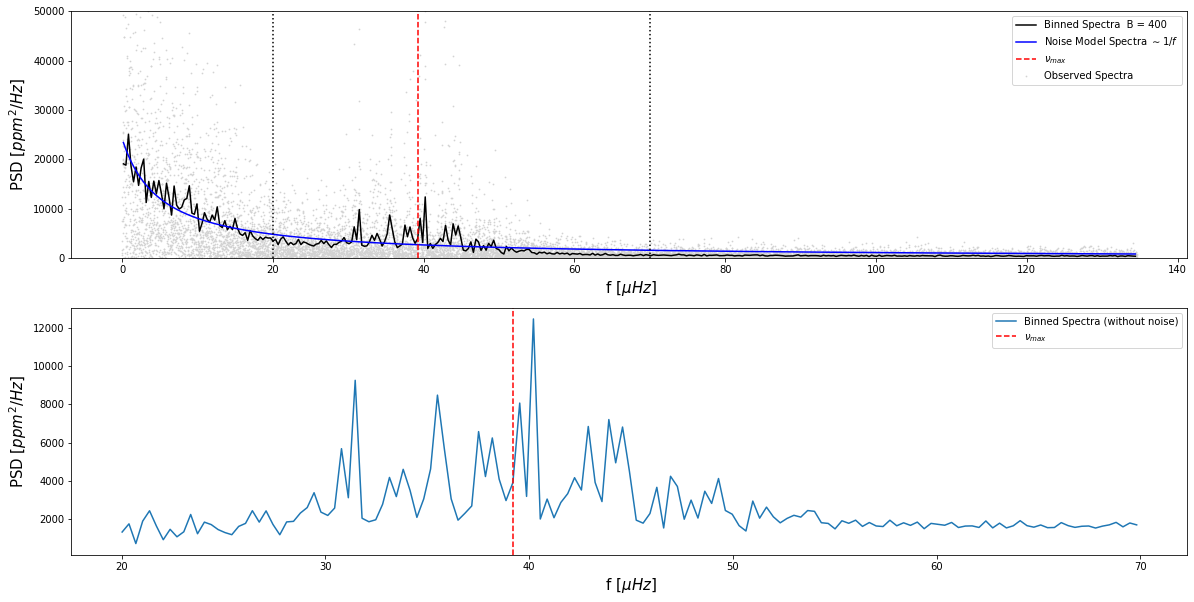

In [44]:

def noise_model(x,a,b,e):
    return ((10**a)/(x+b)) + 10**e

# Speactral data provided
x = data_spec[:,0]
y=data_spec[:,1]

#only use frequencies up to the nyauist frequency (Half of it since the other half of the spectrum is mostly noise)
ii = x < NyqF_cpd*conver_f/2

#bining
Bin = 400
dnu_bin = np.max(x)/Bin
print("d_nu per bin = {:.2f} microHz".format(dnu_bin))



# Testing with a synthetic spectra
params_test = {"n":5,"l":2,"log_A":8,"log_S0":7,"sigma":5,"Gamma":1.5}
y_test = gen_peaks_set(x,params_test,fixed_ref)


x = x[ii]
y=y[ii]
y_test = y_test[ii]


ymean = np.mean(y)

# binning of x. replace y by y_test for testing MCMC performance 
y_binned, x_binned, _=stats.binned_statistic(x,y,"mean",bins=Bin)
x_binned = np.array([0.5*(x_binned[i]+x_binned[i+1]) for i in range(len(x_binned)-1)])

# fit noise data
popt,pocv = curve_fit(noise_model,x_binned,y_binned,p0=[7,20,6])
y_noise = noise_model(x_binned,*popt)
y_corrected = y_binned-y_noise+ymean

# for fitting  only use the interval from 20 to 70 microHz
chop =[20,70]
jj  = np.logical_and(x_binned>=chop[0],x_binned<=chop[1])


plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
#plt.plot(x,y_denoised)
plt.scatter(x,y,c="lightgrey",s=0.5,label="Observed Spectra")
plt.plot(x_binned,y_binned,c="k",label="Binned Spectra  B = {}".format(Bin))
plt.plot(x_binned,y_noise,c="b",label="Noise Model Spectra $\sim 1/f$")

plt.axvline(fixed_ref["numax"],c="r",linestyle="--",label="$\\nu_{max}$")
plt.axvline(chop[0],c="k",linestyle=":")
plt.axvline(chop[1],c="k",linestyle=":")
plt.legend()
plt.ylim(0,5e4)
plt.xlabel(" f [$\mu Hz$]",fontsize=15)
plt.ylabel("PSD [$ppm^2 / Hz$]",fontsize=15)


plt.subplot(2,1,2)
plt.plot(x_binned[jj],y_corrected[jj],label="Binned Spectra (without noise)")
plt.axvline(fixed_ref["numax"],c="r",linestyle="--",label="$\\nu_{max}$")

plt.legend()
plt.xlabel(" f [$\mu Hz$]",fontsize=15)
plt.ylabel("PSD [$ppm^2 / Hz$]",fontsize=15)


In [45]:
N_steps = 1e6

param_steps,l_vals = MCMC_fit(x_binned[jj],y_corrected[jj],N_steps,parameters_space,fixed_ref)

 6%    logl: -2.931   best: -2.467  
 13%    logl: -1.029   best: -0.980  
 19%    logl: -1.859   best: -0.631  
 26%    logl: -3.079   best: -0.631  
 33%    logl: -2.496   best: -0.631  
 39%    logl: -2.525   best: -0.631  
 46%    logl: -1.091   best: -0.631  
 53%    logl: -1.879   best: -0.631  
 59%    logl: -1.421   best: -0.580  
 66%    logl: -2.176   best: -0.580  
 73%    logl: -1.229   best: -0.580  
 79%    logl: -2.825   best: -0.580  
 86%    logl: -1.225   best: -0.580  
 93%    logl: -3.421   best: -0.580  
 99%    logl: -3.402   best: -0.580  
Done.


In [48]:
popt #noise fitting params

array([ 5.08402681,  5.00165404, -8.07278076])

n    1.5826 +- 0.8840685720010637
l    0.5148 +- 0.8358115577090328
log_A    1.3455748620736632 +- 0.1675952513377736
sigma    2.548580046573201 +- 0.17555333080398974
Gamma    1.2388977580876603 +- 0.2191615509306291
log_S0    0.18447722074000417 +- 0.10227262470977316


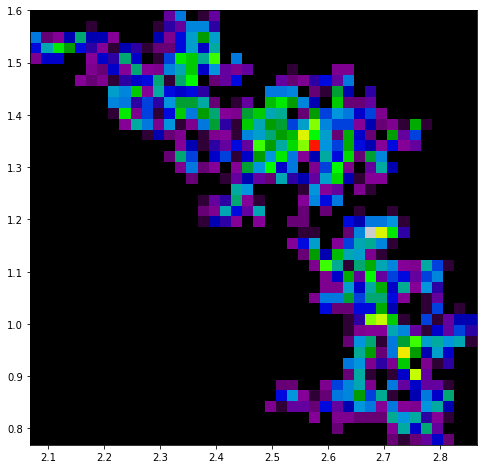

In [49]:
# averaging the last 2000 results wont give a good estimate 
lastN = 5000
par_names = list(parameters_space.keys())
for i in range(len(par_names)):
    print(par_names[i],"  ",np.mean(param_steps[i,-lastN:]),"+-",np.std(param_steps[i,-lastN:]))

plt.figure(figsize=(8,8))
#    for i in range
#plt.plot(param_steps[3,-lastN:],param_steps[4,-lastN:],c="w",linestyle=":")

_=plt.hist2d(param_steps[3,-lastN:],param_steps[4,-lastN:],bins=40,cmap="nipy_spectral")

**NOTE**  The last values of the walk are not a good estimate for the optimal values

In [50]:
import seaborn as sns


df_steps = pd.DataFrame(data=param_steps.T,columns=par_names)
df_steps["log_l"] = l_vals
df_sort=df_steps.sort_values(by="log_l").iloc[-700:]



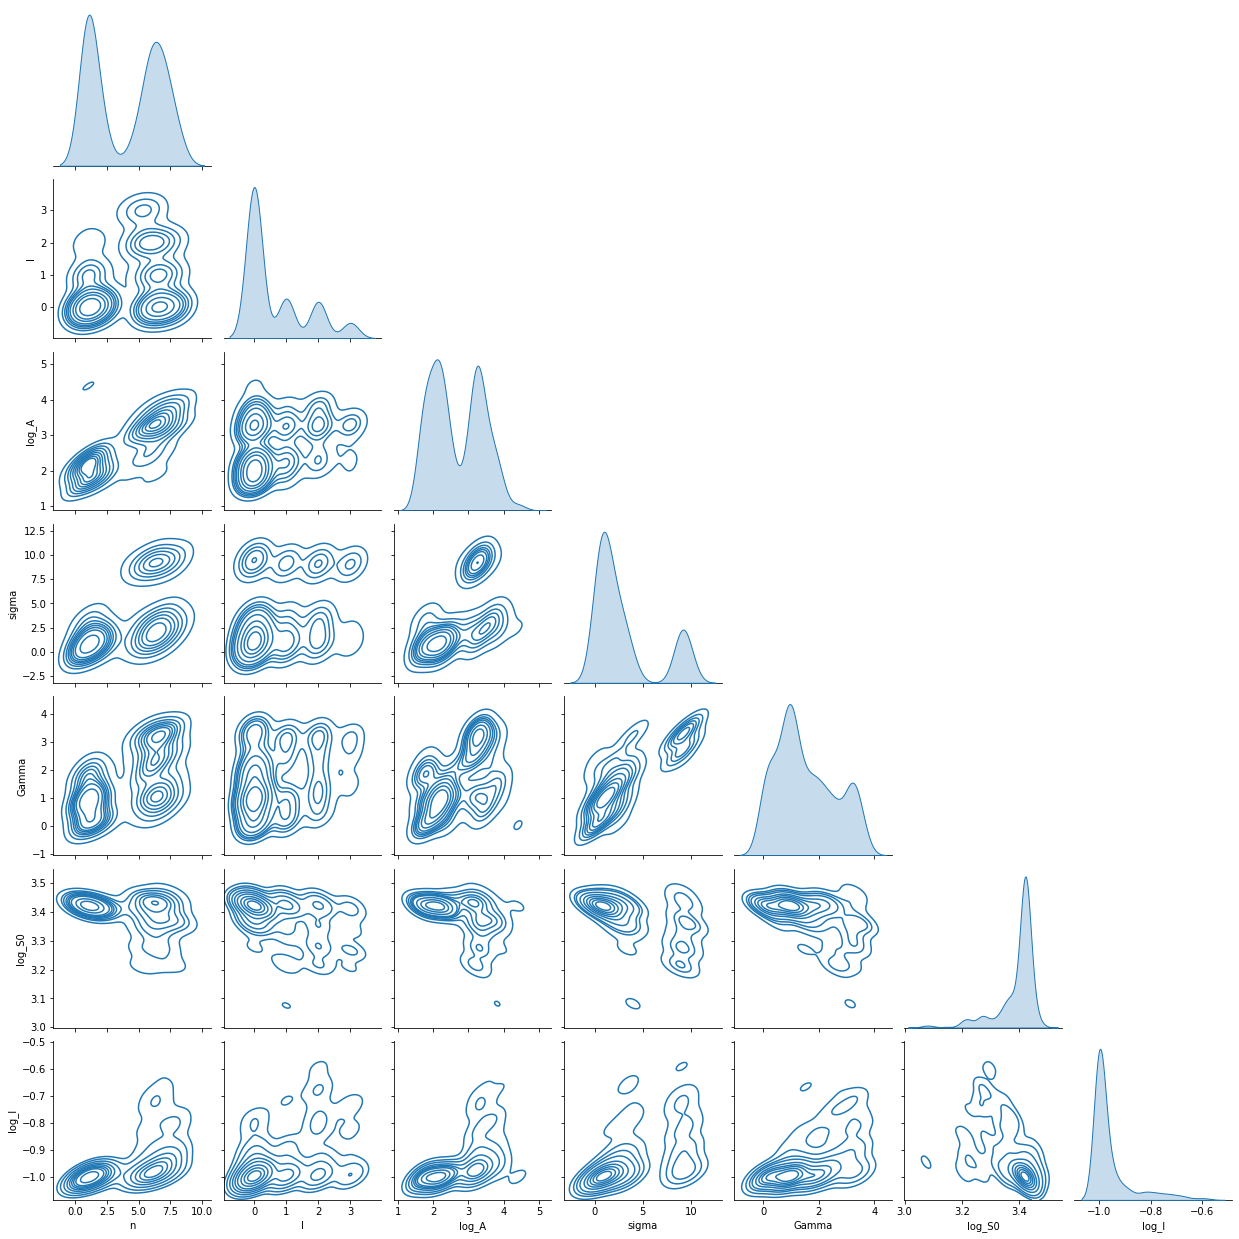

In [51]:
sns.pairplot(df_sort,kind="kde",corner=True,palette="tab20")

Text(0, 0.5, '-Log (Posterior)')

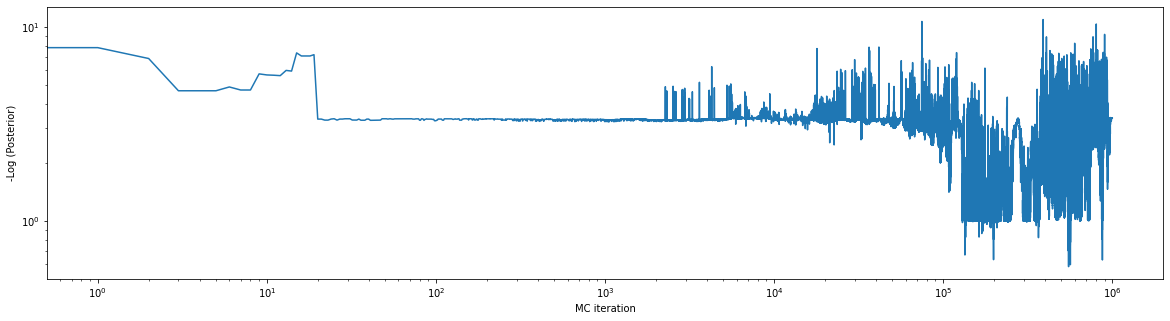

In [52]:
# plotting the log posterior values of the walk
plt.figure(figsize=(20,5))
plt.plot(-l_vals,label="-Log(L)")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("MC iteration")
plt.ylabel("-Log (Posterior)")

In [53]:
# use top 10 log posterior to define optimal parameters
n_top = 10
idxx = np.array(l_vals).argsort()[-n_top:][::-1]
top_params = np.array([param_steps[:,i] for i in idxx])

# optimal paraleters are average of10 best performing models
opt_params = [np.mean(top_params[:,i]) for i in range(len(top_params[0]))]
dev_params = [np.std(top_params[:,i]) for i in range(len(top_params[0]))]
name_par = list(parameters_space.keys())

# estimate parameters and deviations
opt_params = {name_par[j]:opt_params[j] for j in range(len(name_par))}
dev_params = {name_par[j]:dev_params[j] for j in range(len(name_par))}
for p in opt_params:
    if parameters_space[p]["integer"]:
        opt_params[p] = round(opt_params[p])
    print("{}: {:.4e} +- {:.4e}".format(p,opt_params[p],dev_params[p]))

    
#estimate central nu given the found paramters
c_nu_opt = central_nu(opt_params["n"],opt_params["l"],fixed_ref["eps"],fixed_ref["d_nu"],fixed_ref["dol"][1],fixed_ref["alpha"],fixed_ref["n_max"])
print("Central nu : {:.3f} microHz".format(c_nu_opt))

# estimate noise signal, envelope and multiplets
y_model = gen_peaks_set(x_binned,opt_params,fixed_ref)
y_noise_ = noise_model(x_binned,*popt)
y_envelope = height(x_binned,10**opt_params["log_A"],c_nu_opt,opt_params["sigma"])+10**opt_params["log_S0"]

R  = lambda dnu,numax: (numax/fixed_ref["nu_max_sun"])*((dnu/fixed_ref["d_nu_sun"])**(-2)) * (hdr["Teff"]/fixed_ref["Teff_sun"])**(1/2)
M  = lambda dnu,numax: ((numax/fixed_ref["nu_max_sun"])**3) *((dnu/fixed_ref["d_nu_sun"])**(-4)) * (hdr["Teff"]/fixed_ref["Teff_sun"])**(3/2)
print("with estimated data:")
print("Estimated Mass (solar mass): {:.2f} M".format(M(fixed_ref["d_nu"],c_nu_opt)))
print("Estimated Radius (solar radiuss): {:.2f} R".format(R(fixed_ref["d_nu"],c_nu_opt)))
print("Estimated Envelope rotation rate(s): {:.2f} s".format(1/(fixed_ref["d_nu"]*conver_f)))


n: 7.0000e+00 +- 0.0000e+00
l: 2.0000e+00 +- 0.0000e+00
log_A: 3.5597e+00 +- 2.2752e-01
sigma: 6.3067e+00 +- 2.7354e+00
Gamma: 2.7074e+00 +- 6.8967e-01
log_S0: 3.2968e+00 +- 2.5315e-02
Central nu : 39.648 microHz
with estimated data:
Estimated Mass (solar mass): 1.31 M
Estimated Radius (solar radiuss): 10.59 R
Estimated Envelope rotation rate(s): 0.02 s


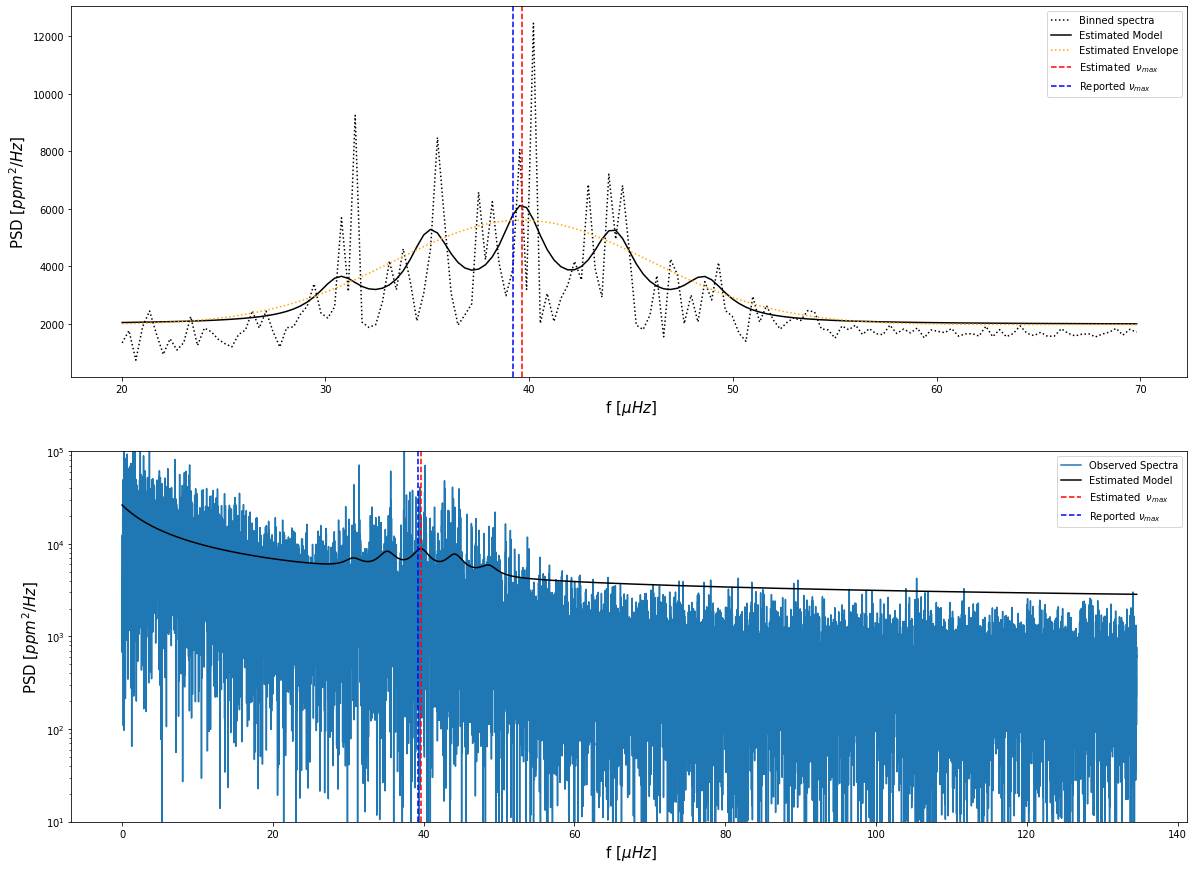

In [54]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
plt.plot(x_binned[jj],y_corrected[jj],"k:",label = "Binned spectra")
plt.plot(x_binned[jj],y_model[jj],"k",label = "Estimated Model")
plt.plot(x_binned[jj],y_envelope[jj],"orange",linestyle=":",label = "Estimated Envelope")
plt.axvline(c_nu_opt,c="r",linestyle="--",label="Estimated  $\\nu_{max}$")
plt.axvline(fixed_ref["numax"],c="b",linestyle="--",label="Reported $\\nu_{max}$")
plt.legend()
plt.xlabel(" f [$\mu Hz$]",fontsize=15)
plt.ylabel("PSD [$ppm^2 / Hz$]",fontsize=15)
plt.subplot(2,1,2)
y_model_whole = gen_peaks_set(x,opt_params,fixed_ref)
y_noise_whole = noise_model(x,*popt)
plt.plot(x,y,label="Observed Spectra")
plt.plot(x,y_model_whole+y_noise_whole,"k",label = "Estimated Model")
plt.yscale("log")
plt.ylim(1e1,1e5)
plt.xlabel(" f [$\mu Hz$]",fontsize=15)
plt.ylabel("PSD [$ppm^2 / Hz$]",fontsize=15)
plt.axvline(c_nu_opt,c="r",linestyle="--",label="Estimated  $\\nu_{max}$")
plt.axvline(fixed_ref["numax"],c="b",linestyle="--",label="Reported $\\nu_{max}$")
plt.legend()

### Multiplet testing

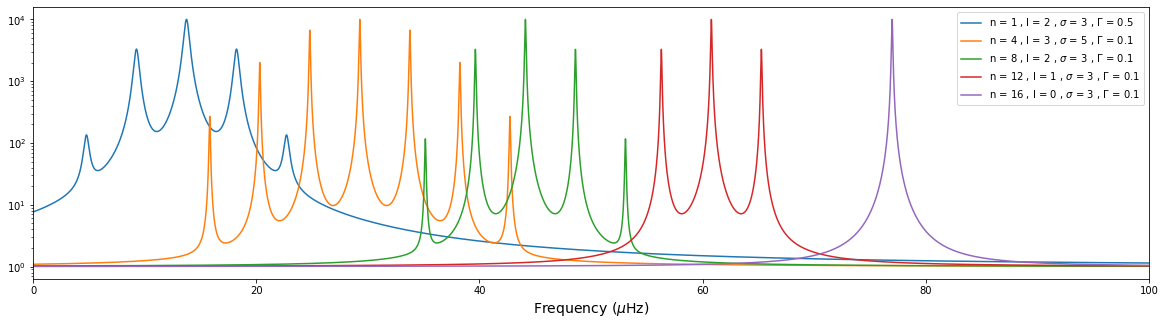

In [55]:
x = frequencyLS*conver_f
y = powerLS
#x = data_spec[:,0]*conver_f
#y=data_spec[:,1]

ii = x < NyqF_cpd*conver_f/2

params_test = {"n":1,"l":2,"log_A":4,"log_S0":0,"sigma":3,"Gamma":0.5}
y_test1 = gen_peaks_set(x[ii],params_test,fixed_ref)
params_test = {"n":4,"l":3,"log_A":4,"log_S0":0,"sigma":5,"Gamma":0.1}
y_test2 = gen_peaks_set(x[ii],params_test,fixed_ref)
params_test = {"n":8,"l":2,"log_A":4,"log_S0":0,"sigma":3,"Gamma":0.1}
y_test3 = gen_peaks_set(x[ii],params_test,fixed_ref)
params_test = {"n":12,"l":1,"log_A":4,"log_S0":0,"sigma":3,"Gamma":0.1}
y_test4 = gen_peaks_set(x[ii],params_test,fixed_ref)
params_test = {"n":16,"l":0,"log_A":4,"log_S0":0,"sigma":3,"Gamma":0.1}
y_test5 = gen_peaks_set(x[ii],params_test,fixed_ref)

plt.figure(figsize=(20,5))
plt.plot(x[ii],y_test1,label="n = 1 , l = 2 , $\sigma$ = 3 , $\Gamma$ = 0.5")
plt.plot(x[ii],y_test2,label="n = 4 , l = 3 , $\sigma$ = 5 , $\Gamma$ = 0.1")
plt.plot(x[ii],y_test3,label="n = 8 , l = 2 , $\sigma$ = 3 , $\Gamma$ = 0.1")
plt.plot(x[ii],y_test4,label="n = 12 , l = 1 , $\sigma$ = 3 , $\Gamma$ = 0.1")
plt.plot(x[ii],y_test5,label="n = 16 , l = 0 , $\sigma$ = 3 , $\Gamma$ = 0.1")
plt.xlim(0,100)
plt.yscale("log")
plt.xlabel("Frequency ($\mu$Hz)",fontsize=14)
plt.legend()

In [63]:
echelle.interact_echelle(data_spec[:,0],data_spec[:,1],fixed_ref["d_nu"]-1,fixed_ref["d_nu"]+1)